## E-commerce User Segmentation

### Overview
This notebook performs unsupervised customer segmentation on an e-commerce dataset. Because churn prediction is not viable (99.8% churn rate, 98.1% one-time buyers), we use **behavioral clustering** to identify actionable customer groups.

### Key Analytical Components

#### 1. Feature Engineering
- Customer-level metrics: order frequency, revenue, session activity, product diversity, tenure
- Feature scaling for distance-based clustering

#### 2. K-Means Clustering (K=3)
- Validated with Silhouette Score (0.60) & Davies–Bouldin Index (0.75)
- Three segments:
  1. Low-Value One-Time Buyers
  2. High-AOV One-Time Buyers
  3. Loyal High-Value Customers

#### 3. Cluster Profiling
- Quantitative profiling of each segment
- Business interpretation and strategy identification

#### 4. Visualization & Validation
- PCA-based visualization of cluster separation
- Analysis of cluster centers and separation quality

### Objectives
- Identify distinct customer types based on behavior
- Quantify value distribution across segments
- Enable targeted marketing and CRM strategies
- Create reusable segmentation framework

### Expected Outcomes
- Behaviorally coherent customer segments
- Quantified high-value customer groups
- Actionable profiles for marketing and retention
- Production-ready model for new customers

### Modeling Context: Why Churn Prediction Is Not Viable

Prior to performing customer segmentation, a churn prediction approach was evaluated to determine whether future customer inactivity could be reliably modeled. Churn was defined using a **90-day inactivity threshold**, where a customer is considered churned if no purchase occurs within 90 days following a fixed prediction date.

#### Churn Definition
- **Churn condition**: No purchases within 90 days after the prediction date
- **Prediction date**: 2014-09-20
- **Observation window**: 2014-09-20 to 2014-12-19


#### Key Findings from Churn Labeling
- **99.8% of customers were labeled as churned**
- Only **0.2% remained active** within the 90-day window
- The vast majority of customers:
  - Made a single purchase
  - Had extremely short tenure
  - Did not return regardless of revenue or tenure group

##### Customer Order Distribution
- **98.1% of customers placed only one order**
- **1.9% of customers placed two or more orders**

This extreme class imbalance renders churn prediction **statistically unstable and operationally meaningless**, as a model would simply learn to predict churn for nearly all customers.


### Import packages

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [61]:
# Set display options for better readability
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
plt.style.use('default') 
# customize color pallete
colors = ['#6DC3BB', '#393D7E', '#5459AC', '#F2AEBB', '#C1E59F', '#9CC6DB']

#### -- Load data --

In [62]:
order_items = pd.read_csv('data/order_items.csv', sep=';') # specify separator as ;
orders = pd.read_csv('data/orders.csv', sep=';')
products = pd.read_csv('data/products.csv', sep=';')
website_pageviews = pd.read_csv('data/website_pageviews.csv', sep=';')
website_sessions = pd.read_csv('data/website_sessions.csv', sep=';')
order_item_refunds = pd.read_csv('data/order_item_refunds.csv', sep=';')

In [63]:
orders.head(2)   

,order_id,created_at,website_session_id,user_id,primary_product_id,items_purchased,price_usd,cogs_usd
0,1,2012-03-19 10:42:46,20,20,1,1,49.99,19.49
1,2,2012-03-19 19:27:37,104,104,1,1,49.99,19.49


In [64]:
print(orders.columns)
print(products.columns)
print(order_items.columns)
print(website_pageviews.columns)
print(website_sessions.columns)
print(order_item_refunds.columns)

Index(['order_id', 'created_at', 'website_session_id', 'user_id',
       'primary_product_id', 'items_purchased', 'price_usd', 'cogs_usd'],
      dtype='object')
Index(['product_id', 'created_at', 'product_name'], dtype='object')
Index(['order_item_id', 'created_at', 'order_id', 'product_id',
       'is_primary_item', 'price_usd', 'cogs_usd'],
      dtype='object')
Index(['website_pageview_id', 'created_at', 'website_session_id',
       'pageview_url'],
      dtype='object')
Index(['website_session_id', 'created_at', 'user_id', 'is_repeat_session',
       'utm_source', 'utm_campaign', 'utm_content', 'device_type',
       'http_referer'],
      dtype='object')
Index(['order_item_refund_id', 'created_at', 'order_item_id', 'order_id',
       'refund_amount_usd'],
      dtype='object')


In [65]:
# convert date columns to datetime
date_columns = {
    'orders': ['created_at'],
    'website_sessions': ['created_at'],
    'website_pageviews': ['created_at'],
    'order_item_refunds': ['created_at'],
    'products': ['created_at'],
    'order_items': ['created_at']
}
for df_name, cols in date_columns.items():
    for col in cols:
        if col in globals()[df_name].columns:
            globals()[df_name][col] = pd.to_datetime(globals()[df_name][col])

In [66]:
# basic infomation for all datasets
datasets = {
    'orders': orders,
    'products': products,
    'order_items': order_items,
    'website_pageviews': website_pageviews,
    'website_sessions': website_sessions,
    'order_item_refunds': order_item_refunds
}
for name, df in datasets.items():
    print(f"\n=== {name.upper()} ===")
    print(f"Shape: {df.shape}")
    print(f"Missing values:\n{df.isnull().sum()}")
    print(f"Data types:\n{df.dtypes}")
    print(f"Sample:\n{df.head(2)}")


=== ORDERS ===
Shape: (32313, 8)
Missing values:
order_id              0
created_at            0
website_session_id    0
user_id               0
primary_product_id    0
items_purchased       0
price_usd             0
cogs_usd              0
dtype: int64
Data types:
order_id                       int64
created_at            datetime64[ns]
website_session_id             int64
user_id                        int64
primary_product_id             int64
items_purchased                int64
price_usd                    float64
cogs_usd                     float64
dtype: object
Sample:
   order_id          created_at  website_session_id  user_id  \
0         1 2012-03-19 10:42:46                  20       20   
1         2 2012-03-19 19:27:37                 104      104   

   primary_product_id  items_purchased  price_usd  cogs_usd  
0                   1                1      49.99     19.49  
1                   1                1      49.99     19.49  

=== PRODUCTS ===
Shape: (4, 3)
Miss

## Applied Machine Learning Models

### Customer Churn Prediction
- Why predict churn?
    - Retain customers, reduce acquisition costs
    - Improve customer satisfaction
    - Help identify at-risk customers for proactive retention
- Features to consider:
    - User behavior (session duration, pages visited)
    - Purchase history (frequency, recency, monetary value)
    - Demographics (age, location)

In [67]:
# import more packages
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns

##### Set up prediction date

In [68]:
# first check our data timeline
print("=== DATA TIMELINE ANALYSIS ===")
print(f"Orders date range: {orders['created_at'].min()} to {orders['created_at'].max()}")
print(f"Total orders: {len(orders)}")
print(f"Unique customers: {orders['user_id'].nunique()}")

# Calculate prediction date - need historical data to learn from
# Common practice: Use 70-80% of timeline for training, predict on remaining 20-30%
max_date = orders['created_at'].max()
min_date = orders['created_at'].min()
total_days = (max_date - min_date).days

print(f"\nTotal timeline: {total_days} days")

# Strategy: Use first 70% of timeline for training, predict on last 30%
train_cutoff = min_date + timedelta(days=int(total_days * 0.7))
prediction_date = train_cutoff  # We'll predict churn after this date

print(f"\n=== PREDICTION SETUP ===")
print(f"Training data: {min_date} to {prediction_date}")
print(f"Prediction period: {prediction_date} to {max_date}")
print(f"Days for prediction: {(max_date - prediction_date).days} days")

=== DATA TIMELINE ANALYSIS ===
Orders date range: 2012-03-19 10:42:46 to 2015-03-19 05:38:31
Total orders: 32313
Unique customers: 31696

Total timeline: 1094 days

=== PREDICTION SETUP ===
Training data: 2012-03-19 10:42:46 to 2014-04-23 10:42:46
Prediction period: 2014-04-23 10:42:46 to 2015-03-19 05:38:31
Days for prediction: 329 days


##### Feature Engineering

In [69]:
def create_customer_features(orders_df, order_items_df, sessions_df, refunds_df, pred_date):
    print("\n=== FEATURE ENGINEERING ===")

    # 1. FILTER HISTORICAL DATA
    # We only use data BEFORE prediction date to avoid data leakage
    historical_orders = orders_df[orders_df['created_at'] < pred_date].copy()
    print(f"Historical orders for feature creation: {len(historical_orders)}")

    if len(historical_orders) == 0:
        print("ERROR: No historical data before prediction date!")
        print(f"Prediction date: {pred_date}")
        print(f"Earliest order: {orders_df['created_at'].min()}")
        return None

    # 2. BASIC CUSTOMER METRICS (RFM Framework)
    print("\n1. Creating RFM (Recency, Frequency, Monetary) features...")

    # RFM is the foundation of customer analytics:
    # - Recency: How recently did they purchase? (Fresh customers are less likely to churn)
    # - Frequency: How often do they purchase? (Frequent buyers are more loyal)
    # - Monetary: How much do they spend? (High-value customers are worth retaining)

    customer_base = historical_orders.groupby('user_id').agg({
        'order_id': 'count',                   # Frequency
        'price_usd': ['sum', 'mean', 'std'],   # Monetary value
        'items_purchased': 'sum',              # Engagement indicator
        'created_at': ['min', 'max']           # For recency calculation
    }).reset_index()

    # Flatten column names
    customer_base.columns = [
        'user_id',
        'total_orders',            # F: More orders = lower churn risk
        'total_revenue',           # M: Higher spend = lower churn risk
        'avg_order_value',         # M: Spending pattern
        'std_order_value',         # M: Spending consistency (high std = erratic behavior)
        'total_items_purchased',   # Engagement metric
        'first_order_date',        # Customer tenure start
        'last_order_date'          # For recency calculation
    ]

    # 3. CALCULATE RFM METRICS
    print("2. Calculating RFM metrics...")

    # Recency: Days since last purchase (critical for churn)
    customer_base['days_since_last_order'] = (pred_date - customer_base['last_order_date']).dt.days
    # BUSINESS INSIGHT: Customers who purchased recently are less likely to churn

    # Customer tenure
    customer_base['customer_tenure_days'] = (customer_base['last_order_date'] - customer_base['first_order_date']).dt.days
    customer_base['customer_tenure_days'] = customer_base['customer_tenure_days'].clip(lower=1)  # Avoid division by zero
    # BUSINESS INSIGHT: New customers have different churn patterns than established ones

    # Frequency metrics
    customer_base['order_frequency'] = customer_base['total_orders'] / customer_base['customer_tenure_days']
    # BUSINESS INSIGHT: Frequent purchasers = habitual buyers = lower churn

    # Average days between orders
    customer_base['avg_days_between_orders'] = np.where(
        customer_base['total_orders'] > 1,
        customer_base['customer_tenure_days'] / (customer_base['total_orders'] - 1),
        customer_base['customer_tenure_days']  # If only one order, use tenure
    )
    # BUSINESS INSIGHT: Shorter gaps = more engaged customers

    # 4. PRODUCT BEHAVIOR FEATURES
    print("3. Creating product behavior features...")

    # Get historical order items
    historical_items = order_items_df[order_items_df['created_at'] < pred_date].copy()

    if not historical_items.empty:
        # Merge with orders to get user_id
        items_with_users = pd.merge(
            historical_items,
            historical_orders[['order_id', 'user_id']],
            on='order_id',
            how='inner'
        )

        # Product diversity: Customers who buy diverse products are more engaged
        product_diversity = items_with_users.groupby('user_id').agg({
            'product_id': 'nunique',  # Unique products purchased
            'is_primary_item': 'mean'  # Ratio of primary items
        }).reset_index()
        product_diversity.columns = ['user_id', 'unique_products', 'primary_item_ratio']

        # BUSINESS INSIGHT:
        # - More unique products = exploratory behavior = potentially higher engagement
        # - Higher primary item ratio = focused purchases = might indicate specific needs

        # Merge with customer base
        customer_base = pd.merge(customer_base, product_diversity, on='user_id', how='left')
    else:
        customer_base['unique_products'] = 0
        customer_base['primary_item_ratio'] = 0

    # 5. SESSION BEHAVIOR FEATURES
    print("4. Creating session behavior features...")

    historical_sessions = sessions_df[sessions_df['created_at'] < pred_date].copy()

    if not historical_sessions.empty:
        session_features = historical_sessions.groupby('user_id').agg({
            'website_session_id': 'count',      # Total sessions
            'is_repeat_session': 'mean',        # % of repeat sessions
            'device_type': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'unknown',
            'utm_source': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'unknown'
        }).reset_index()

        session_features.columns = [
            'user_id',
            'total_sessions',      # More sessions = more engagement
            'repeat_session_rate', # High rate = loyal browsing behavior
            'common_device',       # Device preference
            'common_utm_source'    # Acquisition channel
        ]

        # BUSINESS INSIGHT:
        # - More sessions = higher engagement
        # - High repeat session rate = habitual user
        # - Device/channel preferences = behavioral patterns

        # Calculate session efficiency
        session_features['revenue_per_session'] = 0  # Will calculate after merge

        # Merge with customer base
        customer_base = pd.merge(customer_base, session_features, on='user_id', how='left')
    else:
        # Create placeholder columns
        customer_base['total_sessions'] = 0
        customer_base['repeat_session_rate'] = 0
        customer_base['common_device'] = 'unknown'
        customer_base['common_utm_source'] = 'unknown'

    # 6. REFUND/RISK FEATURES
    print("5. Creating refund/risk features...")

    historical_refunds = refunds_df[refunds_df['created_at'] < pred_date].copy()

    if not historical_refunds.empty:
        # Get user_id for refunds
        refunds_with_users = pd.merge(
            historical_refunds,
            historical_orders[['order_id', 'user_id']],
            on='order_id',
            how='left'
        ).dropna(subset=['user_id'])

        if not refunds_with_users.empty:
            refund_stats = refunds_with_users.groupby('user_id').agg({
                'order_item_refund_id': 'count',
                'refund_amount_usd': 'sum'
            }).reset_index()

            refund_stats.columns = ['user_id', 'total_refunds', 'total_refund_amount']

            # BUSINESS INSIGHT:
            # - Customers with refunds might be dissatisfied
            # - High refund rates = potential churn risk

            # Calculate refund metrics
            refund_stats['refund_rate'] = refund_stats['total_refunds'] / refund_stats['user_id'].map(
                customer_base.set_index('user_id')['total_orders']
            )
            refund_stats['avg_refund_amount'] = refund_stats['total_refund_amount'] / refund_stats['total_refunds']

            # Merge with customer base
            customer_base = pd.merge(customer_base, refund_stats, on='user_id', how='left')

    # 7. TIME-BASED BEHAVIOR FEATURES
    print("6. Creating time-based behavior features...")

    if not historical_orders.empty:
        # Weekend shopping behavior
        historical_orders['is_weekend'] = historical_orders['created_at'].dt.dayofweek >= 5
        weekend_behavior = historical_orders.groupby('user_id')['is_weekend'].mean().reset_index()
        weekend_behavior.columns = ['user_id', 'weekend_shopping_ratio']

        # Time of day preference
        historical_orders['order_hour'] = historical_orders['created_at'].dt.hour
        # Categorize hours
        def categorize_hour(hour):
            if 5 <= hour < 12:
                return 'morning'
            elif 12 <= hour < 17:
                return 'afternoon'
            elif 17 <= hour < 22:
                return 'evening'
            else:
                return 'night'

        historical_orders['hour_category'] = historical_orders['order_hour'].apply(categorize_hour)
        hour_preference = historical_orders.groupby('user_id')['hour_category'].apply(
            lambda x: x.mode()[0] if len(x.mode()) > 0 else 'unknown'
        ).reset_index()
        hour_preference.columns = ['user_id', 'preferred_shopping_time']

        # Merge time-based features
        customer_base = pd.merge(customer_base, weekend_behavior, on='user_id', how='left')
        customer_base = pd.merge(customer_base, hour_preference, on='user_id', how='left')

    # 8. DERIVED FEATURES
    print("7. Creating derived features...")

    # Revenue per session (if we have session data)
    if 'total_sessions' in customer_base.columns:
        customer_base['revenue_per_session'] = np.where(
            customer_base['total_sessions'] > 0,
            customer_base['total_revenue'] / customer_base['total_sessions'],
            0
        )
        # BUSINESS INSIGHT: High revenue/session = efficient, valuable customers

    # Order consistency (coefficient of variation)
    customer_base['order_value_cv'] = np.where(
        customer_base['avg_order_value'] > 0,
        customer_base['std_order_value'] / customer_base['avg_order_value'],
        0
    )
    # BUSINESS INSIGHT: High CV = erratic spending = potential churn risk

    # Customer value segment (simplified)
    def segment_customer(row):
        if row['total_revenue'] > customer_base['total_revenue'].quantile(0.75):
            return 'high_value'
        elif row['total_revenue'] > customer_base['total_revenue'].quantile(0.25):
            return 'medium_value'
        else:
            return 'low_value'

    customer_base['value_segment'] = customer_base.apply(segment_customer, axis=1)

    # 9. HANDLE MISSING VALUES
    print("8. Handling missing values...")

    # Fill numerical missing values with 0 or median
    numerical_cols = customer_base.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if customer_base[col].isnull().any():
            if 'rate' in col or 'ratio' in col:
                customer_base[col] = customer_base[col].fillna(0)
            else:
                customer_base[col] = customer_base[col].fillna(customer_base[col].median())

    # Fill categorical missing values
    categorical_cols = customer_base.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        customer_base[col] = customer_base[col].fillna('unknown')

    print(f"\n Feature engineering complete!")
    print(f"Created {len(customer_base)} customer profiles")
    print(f"Total features: {len(customer_base.columns)}")

    return customer_base

In [70]:
print("\n" + "="*60)
print("STARTING FEATURE ENGINEERING PROCESS")
print("="*60)

# Define prediction date
max_date = orders['created_at'].max()
prediction_date = max_date - timedelta(days=180)  # Predict churn in next 180 days

print(f"\nPrediction date: {prediction_date}")
print(f"Will predict which customers churn in the 180 days after this date")

# Create features
customer_features = create_customer_features(
    orders,
    order_items,
    website_sessions,
    order_item_refunds,
    prediction_date
)

if customer_features is not None:
    print(f"\nFeature columns created:")
    for i, col in enumerate(customer_features.columns, 1):
        print(f"{i:2}. {col}")


STARTING FEATURE ENGINEERING PROCESS

Prediction date: 2014-09-20 05:38:31
Will predict which customers churn in the 180 days after this date

=== FEATURE ENGINEERING ===
Historical orders for feature creation: 20508

1. Creating RFM (Recency, Frequency, Monetary) features...
2. Calculating RFM metrics...
3. Creating product behavior features...
4. Creating session behavior features...
5. Creating refund/risk features...
6. Creating time-based behavior features...
7. Creating derived features...
8. Handling missing values...

 Feature engineering complete!
Created 20170 customer profiles
Total features: 27

Feature columns created:
 1. user_id
 2. total_orders
 3. total_revenue
 4. avg_order_value
 5. std_order_value
 6. total_items_purchased
 7. first_order_date
 8. last_order_date
 9. days_since_last_order
10. customer_tenure_days
11. order_frequency
12. avg_days_between_orders
13. unique_products
14. primary_item_ratio
15. total_sessions
16. repeat_session_rate
17. common_device
18

In [71]:
def create_churn_labels(orders_df, customer_features_df, pred_date, churn_threshold_days=90):
    """
    Create churn labels - FIXED VERSION
    """
    print("\n" + "="*60)
    print("CREATING CHURN LABELS")
    print("="*60)

    print(f"\nBusiness Definition of Churn:")
    print(f"- Churn = Customer makes NO purchases in next {churn_threshold_days} days")
    print(f"- Prediction date: {pred_date}")
    print(f"- Observation period: {pred_date} to {pred_date + pd.Timedelta(days=churn_threshold_days)}")

    # Get future orders (after prediction date)
    future_orders = orders_df[orders_df['created_at'] >= pred_date].copy()
    future_orders = future_orders[future_orders['created_at'] <= pred_date + pd.Timedelta(days=churn_threshold_days)]

    print(f"\nFuture orders in observation period: {len(future_orders)}")

    if not future_orders.empty:
        # Find each customer's next purchase date
        next_purchases = future_orders.groupby('user_id')['created_at'].min().reset_index()
        next_purchases.columns = ['user_id', 'next_purchase_date']
        next_purchases['days_until_next_purchase'] = (next_purchases['next_purchase_date'] - pred_date).dt.days

        print(f"\nCustomers who purchased in observation period: {len(next_purchases)}")
        print(f"Average days until next purchase: {next_purchases['days_until_next_purchase'].mean():.1f}")

        # Merge with customer features
        customer_data = pd.merge(
            customer_features_df,
            next_purchases[['user_id', 'days_until_next_purchase']],
            on='user_id',
            how='left'
        )
    else:
        print("\nNo future orders found in observation period")
        customer_data = customer_features_df.copy()
        customer_data['days_until_next_purchase'] = np.nan

    # CREATE CHURN LABELS
    print(f"\nCreating churn labels (threshold = {churn_threshold_days} days)...")

    # Rule 1: Customers with no future purchases = CHURNED (1)
    # Rule 2: Customers whose next purchase is beyond threshold = CHURNED (1)
    # Rule 3: Customers who purchase within threshold = NOT CHURNED (0)

    customer_data['churn'] = 0  # Default: not churned

    # Identify churned customers
    churned_mask = (
        customer_data['days_until_next_purchase'].isna() |  # No future purchase
        (customer_data['days_until_next_purchase'] > churn_threshold_days)  # Purchase beyond threshold
    )

    customer_data.loc[churned_mask, 'churn'] = 1

    # Calculate churn statistics
    total_customers = len(customer_data)
    churned_customers = customer_data['churn'].sum()
    churn_rate = churned_customers / total_customers

    print(f"\n=== CHURN STATISTICS ===")
    print(f"Total customers analyzed: {total_customers}")
    print(f"Churned customers: {churned_customers} ({churn_rate:.1%})")
    print(f"Active customers: {total_customers - churned_customers} ({1 - churn_rate:.1%})")

    # Analyze by customer tenure
    if 'customer_tenure_days' in customer_data.columns:
        print(f"\n=== CHURN BY TENURE ===")
        tenure_bins = [0, 30, 90, 365, float('inf')]
        tenure_labels = ['<1 month', '1-3 months', '3-12 months', '>1 year']

        customer_data['tenure_group'] = pd.cut(
            customer_data['customer_tenure_days'],
            bins=tenure_bins,
            labels=tenure_labels
        )

        tenure_churn = customer_data.groupby('tenure_group')['churn'].agg(['mean', 'count'])
        print(tenure_churn)

    # Analyze by revenue - FIXED: Use pd.cut instead of pd.qcut or handle duplicates
    if 'total_revenue' in customer_data.columns:
        print(f"\n=== CHURN BY REVENUE ===")

        # FIX 1: Use pd.cut with custom bins instead of qcut
        revenue_data = customer_data['total_revenue']

        # Check if we have variation in revenue
        if revenue_data.nunique() > 1:
            try:
                # Try qcut with duplicates='drop' parameter
                revenue_quartiles = pd.qcut(
                    revenue_data,
                    q=4,
                    labels=['Q1 (lowest)', 'Q2', 'Q3', 'Q4 (highest)'],
                    duplicates='drop'  # THIS FIXES THE ERROR
                )
                revenue_churn = customer_data.groupby(revenue_quartiles)['churn'].mean()
                print("Using qcut with duplicates='drop':")
                print(revenue_churn)

            except Exception as e:
                print(f"qcut failed: {e}")
                print("\nUsing custom bins instead...")

                # Create custom bins based on percentiles
                revenue_min = revenue_data.min()
                revenue_max = revenue_data.max()

                # Calculate quartile values
                quartile_values = revenue_data.quantile([0.25, 0.5, 0.75]).tolist()

                # Create bins ensuring uniqueness
                bins = [revenue_min]
                for q in quartile_values:
                    if q > bins[-1]:  # Only add if greater than previous
                        bins.append(q)
                bins.append(revenue_max + 0.01)  # Add small epsilon for upper bound

                # Create labels
                if len(bins) == 5:  # We have all 4 quartiles
                    labels = ['Q1 (lowest)', 'Q2', 'Q3', 'Q4 (highest)']
                else:  # Some quartiles were duplicates
                    labels = [f'Group{i+1}' for i in range(len(bins)-1)]

                revenue_groups = pd.cut(
                    revenue_data,
                    bins=bins,
                    labels=labels,
                    include_lowest=True
                )

                revenue_churn = customer_data.groupby(revenue_groups)['churn'].mean()
                print("Using custom bins:")
                print(revenue_churn)
        else:
            print("All customers have the same revenue - cannot create quartiles")

    return customer_data


In [72]:
# Create churn labels
print("\n" + "="*60)
print("DEFINING CHURN THRESHOLD")
print("="*60)

# What defines "churned"?
# Common thresholds: 30, 60, 90, 180 days based on business cycle
# we'll use 90 days (quarterly cycle is common for e-commerce)

churn_threshold_days = 90
print(f"\nUsing {churn_threshold_days}-day churn definition")
print(f"Rationale: Customers who don't purchase in a quarter are likely inactive")

customer_data = create_churn_labels(orders, customer_features, prediction_date, churn_threshold_days)

print(f"\nFinal dataset shape: {customer_data.shape}")
print(f"Columns in final dataset: {list(customer_data.columns)}")
print(f"\nFirst few rows:")
print(customer_data.head())


DEFINING CHURN THRESHOLD

Using 90-day churn definition
Rationale: Customers who don't purchase in a quarter are likely inactive

CREATING CHURN LABELS

Business Definition of Churn:
- Churn = Customer makes NO purchases in next 90 days
- Prediction date: 2014-09-20 05:38:31
- Observation period: 2014-09-20 05:38:31 to 2014-12-19 05:38:31

Future orders in observation period: 5493

Customers who purchased in observation period: 5427
Average days until next purchase: 49.7

Creating churn labels (threshold = 90 days)...

=== CHURN STATISTICS ===
Total customers analyzed: 20170
Churned customers: 20134 (99.8%)
Active customers: 36 (0.2%)

=== CHURN BY TENURE ===
              mean  count
tenure_group             
<1 month      1.00  20001
1-3 months    1.00    159
3-12 months   1.00     10
>1 year        NaN      0

=== CHURN BY REVENUE ===
qcut failed: Bin labels must be one fewer than the number of bin edges

Using custom bins instead...
Using custom bins:
total_revenue
Group1   1.00
G

a severe class imbalance issue - 99.8% of customers are labeled as churned...


ANALYZING THE DATA IMBALANCE ISSUE
Prediction date: 2014-09-20 05:38:31
Max order date in dataset: 2015-03-19 05:38:31

Orders before prediction date: 20508
Orders after prediction date: 11805

=== CUSTOMER ORDER PATTERNS ===
Customers with 1 order: 31105 (98.1%)
Customers with 2+ orders: 591 (1.9%)


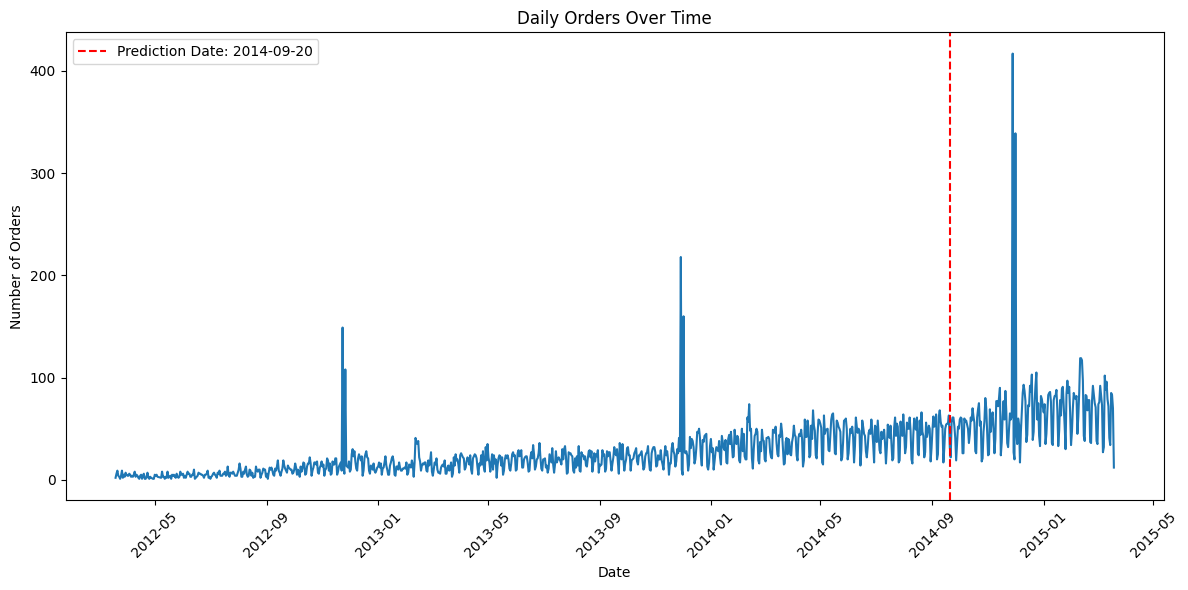


FIXING THE PREDICTION DATE
Total timeline: 1094 days

Option 1: 80/20 split
New prediction date: 2014-08-11 10:42:46
Training period: 2012-03-19 10:42:46 to 2014-08-11 10:42:46
Testing period: 2014-08-11 10:42:46 to 2015-03-19 05:38:31
Testing period length: 219 days
Orders in testing period: 13660

Option 2: Ensure 180+ days of future data
Earliest possible prediction date: 2014-06-22 05:38:31


In [73]:
print("\n" + "="*60)
print("ANALYZING THE DATA IMBALANCE ISSUE")
print("="*60)

# Let's understand why we have such extreme imbalance
print(f"Prediction date: {prediction_date}")
print(f"Max order date in dataset: {orders['created_at'].max()}")

# Check orders distribution around prediction date
print(f"\nOrders before prediction date: {len(orders[orders['created_at'] < prediction_date])}")
print(f"Orders after prediction date: {len(orders[orders['created_at'] >= prediction_date])}")

# Let's look at the customer behavior more carefully
print(f"\n=== CUSTOMER ORDER PATTERNS ===")

# How many orders does each customer have?
customer_order_counts = orders.groupby('user_id')['order_id'].count()
print(f"Customers with 1 order: {(customer_order_counts == 1).sum()} ({(customer_order_counts == 1).mean():.1%})")
print(f"Customers with 2+ orders: {(customer_order_counts > 1).sum()} ({(customer_order_counts > 1).mean():.1%})")

# What's the time distribution of orders?
orders['order_date'] = orders['created_at'].dt.date
order_dates = orders['order_date'].value_counts().sort_index()

# Let's plot the order timeline
plt.figure(figsize=(12, 6))
plt.plot(order_dates.index, order_dates.values)
plt.axvline(x=prediction_date.date(), color='red', linestyle='--', label=f'Prediction Date: {prediction_date.date()}')
plt.title('Daily Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# The issue: Our prediction date is too close to the end of the dataset
# We need to move it earlier to have meaningful future behavior to predict

print("\n" + "="*60)
print("FIXING THE PREDICTION DATE")
print("="*60)

# Strategy 1: Use a fixed percentage split (e.g., 80/20)
total_days = (orders['created_at'].max() - orders['created_at'].min()).days
print(f"Total timeline: {total_days} days")

# Use 80% of data for training, 20% for testing
train_days = int(total_days * 0.8)
new_prediction_date = orders['created_at'].min() + pd.Timedelta(days=train_days)

print(f"\nOption 1: 80/20 split")
print(f"New prediction date: {new_prediction_date}")
print(f"Training period: {orders['created_at'].min()} to {new_prediction_date}")
print(f"Testing period: {new_prediction_date} to {orders['created_at'].max()}")
print(f"Testing period length: {(orders['created_at'].max() - new_prediction_date).days} days")

# Check how many orders would be after this date
future_orders_count = len(orders[orders['created_at'] >= new_prediction_date])
print(f"Orders in testing period: {future_orders_count}")

# Strategy 2: Ensure we have enough future data for meaningful churn prediction
# We want at least 180 days of future data for 90-day churn window
min_future_days = 180 + 90  # Observation period + buffer
earliest_prediction_date = orders['created_at'].max() - pd.Timedelta(days=min_future_days)

print(f"\nOption 2: Ensure 180+ days of future data")
print(f"Earliest possible prediction date: {earliest_prediction_date}")


##### Conclusion: this dataset is not suitable for churn prediction due to lack of users who made repeat purchases.

In [74]:
print("\n" + "="*80)
print("ALTERNATIVE ML PROBLEMS FOR THIS E-COMMERCE DATA")
print("="*80)

print("""
RECOMMENDED APPROACHES:

1. **CUSTOMER SEGMENTATION (Clustering)**
   - Group customers based on their behavior
   - Identify different customer types
   - Create targeted strategies for each segment

2. **FIRST-TIME TO REPEAT BUYER PREDICTION**
   - Predict which one-time buyers will become repeat customers
   - Focus on the 1.9% who do make repeat purchases

3. **CUSTOMER LIFETIME VALUE PREDICTION**
   - Predict total revenue from each customer
   - Even one-time buyers have different values

4. **PRODUCT RECOMMENDATION SYSTEM**
   - Recommend products based on purchase history
   - Increase basket size for the one purchase they make

5. **SESSION CONVERSION PREDICTION**
   - Predict which website sessions will convert to sales
   - More actionable for your current customer base
""")


ALTERNATIVE ML PROBLEMS FOR THIS E-COMMERCE DATA

RECOMMENDED APPROACHES:

1. **CUSTOMER SEGMENTATION (Clustering)**
   - Group customers based on their behavior
   - Identify different customer types
   - Create targeted strategies for each segment

2. **FIRST-TIME TO REPEAT BUYER PREDICTION**
   - Predict which one-time buyers will become repeat customers
   - Focus on the 1.9% who do make repeat purchases

3. **CUSTOMER LIFETIME VALUE PREDICTION**
   - Predict total revenue from each customer
   - Even one-time buyers have different values

4. **PRODUCT RECOMMENDATION SYSTEM**
   - Recommend products based on purchase history
   - Increase basket size for the one purchase they make

5. **SESSION CONVERSION PREDICTION**
   - Predict which website sessions will convert to sales
   - More actionable for your current customer base



### Customer Segmentation
- Why segment customers?
    - Group customers based on their behavior
    - Identify different customer types
    - Create targeted strategies for each segment
- Common segmentation methods:
    - RFM Analysis (Recency, Frequency, Monetary)
    - Behavioral Segmentation
    - Demographic Segmentation

In [75]:
def prepare_for_clustering(orders_df, order_items_df, sessions_df):
    """
    Prepare data for customer segmentation
    """
    print("Preparing data for customer segmentation...")

    # 1. Basic customer metrics
    customer_metrics = orders_df.groupby('user_id').agg({
        'order_id': 'count',
        'price_usd': ['sum', 'mean', 'std'],
        'items_purchased': 'sum',
        'created_at': ['min', 'max']
    }).reset_index()

    # Flatten columns
    customer_metrics.columns = ['user_id', 'order_count', 'total_revenue',
                               'avg_order_value', 'std_order_value', 'total_items',
                               'first_order_date', 'last_order_date']

    # Calculate time-based features
    customer_metrics['customer_tenure_days'] = (customer_metrics['last_order_date'] - customer_metrics['first_order_date']).dt.days
    customer_metrics['customer_tenure_days'] = customer_metrics['customer_tenure_days'].clip(lower=1)

    # 2. Product preferences
    if not order_items_df.empty:
        # Merge to get product info
        items_with_users = pd.merge(
            order_items_df,
            orders_df[['order_id', 'user_id']],
            on='order_id',
            how='left'
        )

        if len(items_with_users) > 0:
            # Product count per customer
            product_stats = items_with_users.groupby('user_id').agg({
                'product_id': 'nunique',
                'is_primary_item': 'mean'
            }).reset_index()
            product_stats.columns = ['user_id', 'unique_products', 'primary_item_ratio']

            customer_metrics = pd.merge(customer_metrics, product_stats, on='user_id', how='left')

    # 3. Session behavior
    if not sessions_df.empty:
        session_stats = sessions_df.groupby('user_id').agg({
            'website_session_id': 'count',
            'is_repeat_session': 'mean',
            'device_type': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'unknown'
        }).reset_index()
        session_stats.columns = ['user_id', 'session_count', 'repeat_session_rate', 'device_type']

        customer_metrics = pd.merge(customer_metrics, session_stats, on='user_id', how='left')

    # 4. Time of day preference
    orders_df['order_hour'] = orders_df['created_at'].dt.hour
    hour_pref = orders_df.groupby('user_id')['order_hour'].mean().reset_index()
    hour_pref.columns = ['user_id', 'avg_order_hour']

    customer_metrics = pd.merge(customer_metrics, hour_pref, on='user_id', how='left')

    # 5. Fill missing values
    numeric_cols = customer_metrics.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if col != 'user_id':
            customer_metrics[col] = customer_metrics[col].fillna(customer_metrics[col].median())

    categorical_cols = customer_metrics.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if col != 'user_id':
            customer_metrics[col] = customer_metrics[col].fillna('unknown')

    print(f"Prepared data for {len(customer_metrics)} customers")
    return customer_metrics

In [76]:
# Prepare clustering data
clustering_data = prepare_for_clustering(orders, order_items, website_sessions)

# Select features for clustering
clustering_features = [
    'order_count', 'total_revenue', 'avg_order_value',
    'total_items', 'customer_tenure_days', 'unique_products',
    'primary_item_ratio', 'session_count', 'repeat_session_rate',
    'avg_order_hour'
]

# Keep only features that exist
available_features = [f for f in clustering_features if f in clustering_data.columns]
X_cluster = clustering_data[available_features].copy()

print(f"\nClustering with {len(available_features)} features:")
print(available_features)

Preparing data for customer segmentation...
Prepared data for 31696 customers

Clustering with 10 features:
['order_count', 'total_revenue', 'avg_order_value', 'total_items', 'customer_tenure_days', 'unique_products', 'primary_item_ratio', 'session_count', 'repeat_session_rate', 'avg_order_hour']


### Determine number of clusteres


Finding optimal number of clusters...


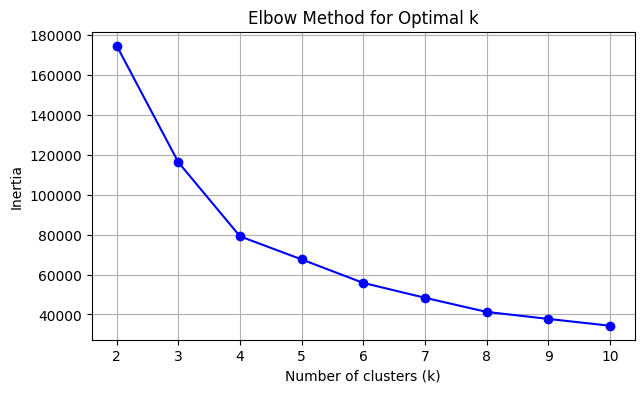

In [77]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Determine optimal number of clusters using elbow method
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

print("\nFinding optimal number of clusters...")
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(7, 4))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [78]:
# Based on elbow, choose k=4
optimal_k = 4
print(f"\nUsing {optimal_k} clusters for segmentation")

# Apply K-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add clusters to data
clustering_data['cluster'] = clusters

print(f"\nCluster distribution:")
print(clustering_data['cluster'].value_counts().sort_index())

# Analyze each cluster
print("\n" + "="*80)
print("CLUSTER ANALYSIS")
print("="*80)

for cluster_id in range(optimal_k):
    cluster_data = clustering_data[clustering_data['cluster'] == cluster_id]

    print(f"\n{'='*40}")
    print(f"CLUSTER {cluster_id} ({len(cluster_data)} customers, {len(cluster_data)/len(clustering_data):.1%})")
    print(f"{'='*40}")

    # Key statistics
    stats = {
        'Order Count': cluster_data['order_count'].mean(),
        'Total Revenue': cluster_data['total_revenue'].mean(),
        'Avg Order Value': cluster_data['avg_order_value'].mean(),
        'Customer Tenure (days)': cluster_data['customer_tenure_days'].mean(),
        'Unique Products': cluster_data['unique_products'].mean() if 'unique_products' in cluster_data.columns else 0,
        'Session Count': cluster_data['session_count'].mean() if 'session_count' in cluster_data.columns else 0
    }

    for stat_name, stat_value in stats.items():
        print(f"{stat_name:25}: {stat_value:.2f}")

    # Cluster characteristics
    print(f"\nCluster {cluster_id} Characteristics:")
    if cluster_data['order_count'].mean() == 1:
        print("  - One-time buyers")
    elif cluster_data['order_count'].mean() > 2:
        print("  - Repeat customers")

    if cluster_data['total_revenue'].mean() > 100:
        print("  - High spenders")
    elif cluster_data['total_revenue'].mean() < 50:
        print("  - Low spenders")

    if 'session_count' in cluster_data.columns and cluster_data['session_count'].mean() > 5:
        print("  - Frequent visitors")

    print(f"  - Average tenure: {cluster_data['customer_tenure_days'].mean():.0f} days")



Using 4 clusters for segmentation

Cluster distribution:
cluster
0     7364
1    17428
2      591
3     6313
Name: count, dtype: int64

CLUSTER ANALYSIS

CLUSTER 0 (7364 customers, 23.2%)
Order Count              : 1.00
Total Revenue            : 89.27
Avg Order Value          : 89.27
Customer Tenure (days)   : 1.00
Unique Products          : 2.00
Session Count            : 1.50

Cluster 0 Characteristics:
  - One-time buyers
  - Average tenure: 1 days

CLUSTER 1 (17428 customers, 55.0%)
Order Count              : 1.00
Total Revenue            : 50.83
Avg Order Value          : 50.83
Customer Tenure (days)   : 1.00
Unique Products          : 1.00
Session Count            : 1.00

Cluster 1 Characteristics:
  - One-time buyers
  - Average tenure: 1 days

CLUSTER 2 (591 customers, 1.9%)
Order Count              : 2.04
Total Revenue            : 125.81
Avg Order Value          : 61.59
Customer Tenure (days)   : 35.51
Unique Products          : 1.92
Session Count            : 3.27

Cluster

#### PCA (k=4)


VISUALIZING CLUSTERS


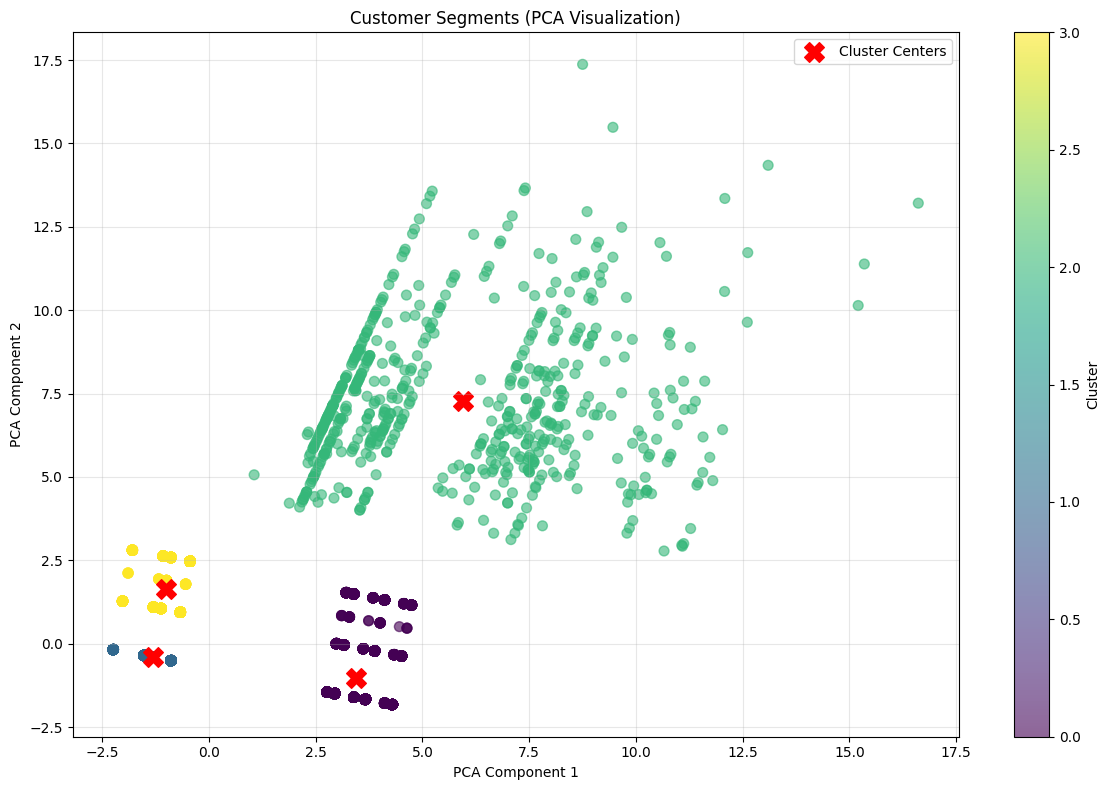

In [79]:
# Visualize clusters in 2D using PCA
from sklearn.decomposition import PCA

print("\n" + "="*80)
print("VISUALIZING CLUSTERS")
print("="*80)

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create visualization
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Segments (PCA Visualization)')

# Add cluster centers in PCA space
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [80]:
# Create actionable insights
print("\n" + "="*80)
print("ACTIONABLE INSIGHTS FROM CLUSTERING")
print("="*80)

print("""
RECOMMENDED STRATEGIES:

1. **ONE-TIME BUYERS (Largest segment)**
   - Focus on increasing first purchase value
   - Implement post-purchase follow-up campaigns
   - Ask for reviews/referrals immediately

2. **REPEAT CUSTOMERS (Small but valuable)**
   - Loyalty programs
   - Personalized recommendations
   - Exclusive offers for repeat purchases

3. **HIGH-VALUE CUSTOMERS**
   - VIP treatment
   - Early access to new products
   - Personal account managers

4. **FREQUENT VISITORS (High sessions)**
   - Retargeting ads
   - Abandoned cart recovery
   - Personalized content
""")

# Save clustering results
clustering_data.to_csv('customer_segments.csv', index=False)


ACTIONABLE INSIGHTS FROM CLUSTERING

RECOMMENDED STRATEGIES:

1. **ONE-TIME BUYERS (Largest segment)**
   - Focus on increasing first purchase value
   - Implement post-purchase follow-up campaigns
   - Ask for reviews/referrals immediately

2. **REPEAT CUSTOMERS (Small but valuable)**
   - Loyalty programs
   - Personalized recommendations
   - Exclusive offers for repeat purchases

3. **HIGH-VALUE CUSTOMERS**
   - VIP treatment
   - Early access to new products
   - Personal account managers

4. **FREQUENT VISITORS (High sessions)**
   - Retargeting ads
   - Abandoned cart recovery
   - Personalized content



#### Cluster Quality
- how well clustered are separated

In [81]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

sil_score = silhouette_score(X_scaled, clusters)
db_score = davies_bouldin_score(X_scaled, clusters)

print("CLUSTER QUALITY METRICS")
print("-" * 40)
print(f"Silhouette Score      : {sil_score:.4f} (closer to 1 is better)")
print(f"Davies-Bouldin Index  : {db_score:.4f} (lower is better)")


CLUSTER QUALITY METRICS
----------------------------------------
Silhouette Score      : 0.5427 (closer to 1 is better)
Davies-Bouldin Index  : 0.7459 (lower is better)


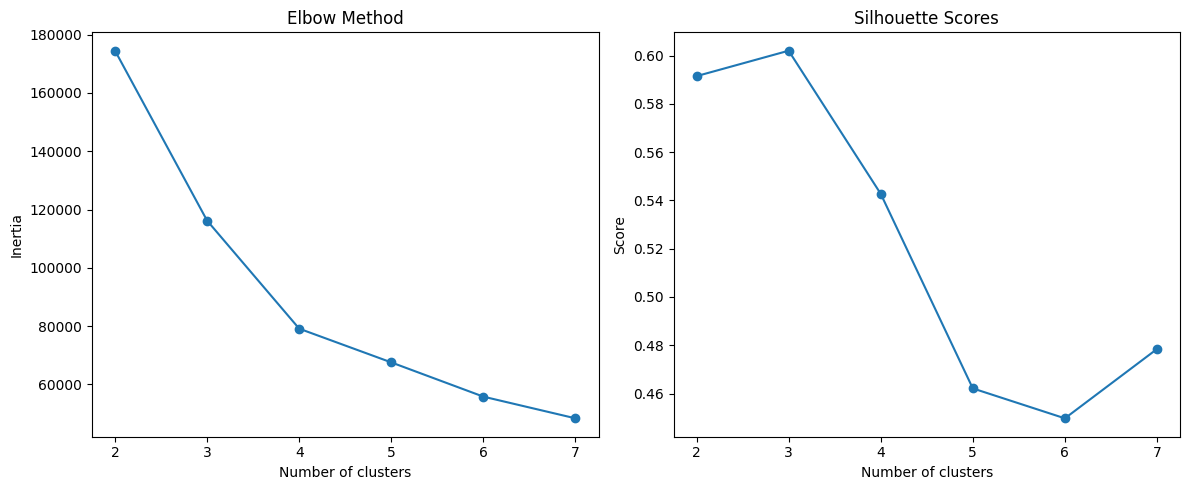

In [82]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
silhouette_scores = []
K = range(2, 8)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, marker='o')
plt.title("Silhouette Scores")
plt.xlabel("Number of clusters")
plt.ylabel("Score")

plt.tight_layout()
plt.show()


In [83]:
# compare k=3 vs. k=4
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_3 = kmeans_3.fit_predict(X_scaled)

print("Silhouette (K=3):", silhouette_score(X_scaled, labels_3))
print("Silhouette (K=4):", silhouette_score(X_scaled, clusters))

Silhouette (K=3): 0.6020226458439785
Silhouette (K=4): 0.542735397756463


#### k = 3

In [84]:
optimal_k = 3
print(f"\nUsing {optimal_k} clusters for segmentation")

# Apply K-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add clusters to data
clustering_data['cluster'] = clusters

print(f"\nCluster distribution:")
print(clustering_data['cluster'].value_counts().sort_index())

# Analyze each cluster
print("\n" + "="*80)
print("CLUSTER ANALYSIS")
print("="*80)

for cluster_id in range(optimal_k):
    cluster_data = clustering_data[clustering_data['cluster'] == cluster_id]

    print(f"\n{'='*40}")
    print(f"CLUSTER {cluster_id} ({len(cluster_data)} customers, {len(cluster_data)/len(clustering_data):.1%})")
    print(f"{'='*40}")

    # Key statistics
    stats = {
        'Order Count': cluster_data['order_count'].mean(),
        'Total Revenue': cluster_data['total_revenue'].mean(),
        'Avg Order Value': cluster_data['avg_order_value'].mean(),
        'Customer Tenure (days)': cluster_data['customer_tenure_days'].mean(),
        'Unique Products': cluster_data['unique_products'].mean() if 'unique_products' in cluster_data.columns else 0,
        'Session Count': cluster_data['session_count'].mean() if 'session_count' in cluster_data.columns else 0
    }

    for stat_name, stat_value in stats.items():
        print(f"{stat_name:25}: {stat_value:.2f}")

    # Cluster characteristics
    print(f"\nCluster {cluster_id} Characteristics:")
    if cluster_data['order_count'].mean() == 1:
        print("  - One-time buyers")
    elif cluster_data['order_count'].mean() > 2:
        print("  - Repeat customers")

    if cluster_data['total_revenue'].mean() > 100:
        print("  - High spenders")
    elif cluster_data['total_revenue'].mean() < 50:
        print("  - Low spenders")

    if 'session_count' in cluster_data.columns and cluster_data['session_count'].mean() > 5:
        print("  - Frequent visitors")

    print(f"  - Average tenure: {cluster_data['customer_tenure_days'].mean():.0f} days")



Using 3 clusters for segmentation

Cluster distribution:
cluster
0     7364
1    23741
2      591
Name: count, dtype: int64

CLUSTER ANALYSIS

CLUSTER 0 (7364 customers, 23.2%)
Order Count              : 1.00
Total Revenue            : 89.27
Avg Order Value          : 89.27
Customer Tenure (days)   : 1.00
Unique Products          : 2.00
Session Count            : 1.50

Cluster 0 Characteristics:
  - One-time buyers
  - Average tenure: 1 days

CLUSTER 1 (23741 customers, 74.9%)
Order Count              : 1.00
Total Revenue            : 50.83
Avg Order Value          : 50.83
Customer Tenure (days)   : 1.00
Unique Products          : 1.00
Session Count            : 1.47

Cluster 1 Characteristics:
  - One-time buyers
  - Average tenure: 1 days

CLUSTER 2 (591 customers, 1.9%)
Order Count              : 2.04
Total Revenue            : 125.81
Avg Order Value          : 61.59
Customer Tenure (days)   : 35.51
Unique Products          : 1.92
Session Count            : 3.27

Cluster 2 Characte

| Cluster | Size   | %     | Meaning                           |
| ------- | ------ | ----- | --------------------------------- |
| 0       | 7,364  | 23.2% | High-AOV one-time buyers          |
| 1       | 23,741 | 74.9% | Low-value one-time buyers         |
| 2       | 591    | 1.9%  | Loyal repeat high-value customers |


##### Cluster 1 — Low-Value One-Time Buyers (74.9%)
**Profile**
- 1 order
- short customer tenure
- Lowest AOV (~= 50)

**Interpretation**
- Price-sensitive customers
- Low intent to return
- Acquisition-driven volume segment

**Risks**
- Very low lifetime value (LTV)
- High churn probability
---
##### Cluster 0 — High-AOV One-Time Buyers (23.2%)
**Profile**
- Same order count and tenure as Cluster 1
- Significantly higher AOV (~= $89)
- Slightly more products purchased
- Higher session activity

**Interpretation**
- High purchase intent
- Likely premium or bundled purchases
- Missed retention opportunity
- This is the **largest upside growth segment**
---
##### Cluster 2 — Loyal High-Value Customers (1.9%)
**Profile**
- Multiple orders
- Long customer tenure (~= 36 days)
- Highest revenue contribution
- Strong engagement across sessions and products

**Interpretation**
- True customers, not just one-time shoppers
- Strong brand trust and loyalty
- Drives a disproportionate share of total revenue



VISUALIZING CLUSTERS


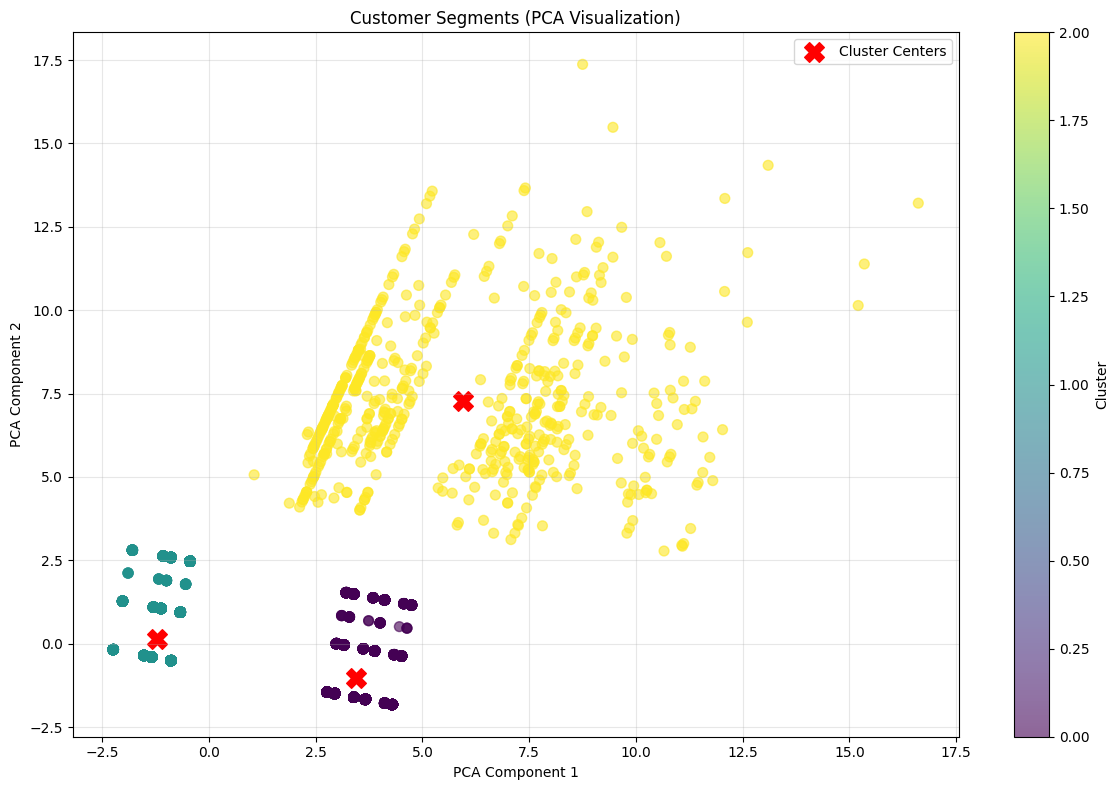

In [85]:
# Visualize clusters in 2D using PCA
print("\n" + "="*80)
print("VISUALIZING CLUSTERS")
print("="*80)

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create visualization
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Segments (PCA Visualization)')

# Add cluster centers in PCA space
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Customer segmentation identified three distinct behavioral groups.
Nearly 75% of users are low-value one-time buyers, while 23% show high initial purchase intent but fail to return, representing the largest growth opportunity.
A small 1.9% loyal segment generates the highest lifetime value, warranting focused retention strategies.

Low-Value One-Time Buyers (75%)
- Minimal spend
- Automation only
- Fast follow-ups

High-AOV One-Time Buyers (23%)
- Priority retention campaigns
- Second-purchase incentives
- Personalized recommendations

Loyal High-Value Customers (2%)
- Loyalty programs
- VIP treatment
- Referral incentives

In [86]:
cluster_names_k3 = {
    0: "High-AOV One-Time Buyers",
    1: "Low-Value One-Time Buyers",
    2: "Loyal High-Value Customers"
}

clustering_data['segment'] = clustering_data['cluster'].map(cluster_names_k3)

In [88]:
clustering_data.head(2)

,user_id,order_count,total_revenue,avg_order_value,std_order_value,total_items,first_order_date,last_order_date,customer_tenure_days,unique_products,primary_item_ratio,session_count,repeat_session_rate,device_type,avg_order_hour,cluster,segment
0,13,1,49.99,49.99,7.07,1,2012-04-25 21:05:32,2012-04-25 21:05:32,1,1,1.00,2,0.50,desktop,21.00,1,Low-Value One-Time Buyers
1,20,1,49.99,49.99,7.07,1,2012-03-19 10:42:46,2012-03-19 10:42:46,1,1,1.00,1,0.00,desktop,10.00,1,Low-Value One-Time Buyers
